In [ ]:
!apt install unzip
!unzip  /content/drive/MyDrive/New_Test_Folder_2.zip -d /content/New_Data

Streaming output truncated to the last 5000 lines.
  inflating: /content/New_Data/New_Test_Folder/2304/495.66.jpg  
  inflating: /content/New_Data/__MACOSX/New_Test_Folder/2304/._495.66.jpg  
  inflating: /content/New_Data/New_Test_Folder/7676/108.14.jpg  
  inflating: /content/New_Data/__MACOSX/New_Test_Folder/7676/._108.14.jpg  
  inflating: /content/New_Data/New_Test_Folder/3010/76.29.jpg  
  inflating: /content/New_Data/__MACOSX/New_Test_Folder/3010/._76.29.jpg  
  inflating: /content/New_Data/New_Test_Folder/6562/278.21.jpg  
  inflating: /content/New_Data/__MACOSX/New_Test_Folder/6562/._278.21.jpg  
  inflating: /content/New_Data/New_Test_Folder/885/0.45.jpg  
  inflating: /content/New_Data/__MACOSX/New_Test_Folder/885/._0.45.jpg  
  inflating: /content/New_Data/New_Test_Folder/4235/314.6.jpg  
  inflating: /content/New_Data/__MACOSX/New_Test_Folder/4235/._314.6.jpg  
  inflating: /content/New_Data/New_Test_Folder/1747/192.17.jpg  
  inflating: /content/New_Data/__MACOSX/New_Test

In [ ]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/waggle-sensor/summer2023/main/Shen/Data/Image_Regression_Data%2BRotates.csv')

In [ ]:
train_data = data[data['Validation'] == False]
val_data = data[data['Validation'] == True]


In [ ]:
import torch
from PIL import Image
from torch.utils.data import Dataset

class SolarIrradianceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Images')]
        image = Image.open(img_name)

        irradiance = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Irradiance')]
        irradiance = torch.tensor(irradiance, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, irradiance

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(360),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = SolarIrradianceDataset(train_data, transform=transform)
val_dataset = SolarIrradianceDataset(val_data, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Load ResNet-50
model_ft = models.resnet50(weights='IMAGENET1K_V1')

# Freeze model parameters
# for param in model_ft.parameters():
#     param.requires_grad = False

num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 1)
model_ft = model_ft.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


In [ ]:
def train_model(model, epochs):
  num_epochs = epochs
  for epoch in range(num_epochs):
      train_loss = 0.0
      val_loss = 0.0
      train_sqrt = 0.0
      val_sqrt = 0.0


      # Training
      model.train()
      for images, irradiances in train_dataloader:

          images = images.to(device)
          irradiances = irradiances.to(device)

          optimizer.zero_grad()

          # Forward + backward + optimize
          outputs = model(images)
          sqrt_loss = torch.sqrt(criterion(outputs, irradiances.view(-1, 1)))
          loss = (criterion(outputs, irradiances.view(-1, 1)))
          loss.backward()
          optimizer.step()

          # training loss
          train_loss += loss.item() * images.size(0)
          train_sqrt += sqrt_loss.item() * images.size(0)

      # Validation
      model.eval()
      with torch.no_grad():
          for images, irradiances in val_dataloader:

              images = images.to(device)
              irradiances = irradiances.to(device)

              outputs = model(images)
              sqrt_loss = torch.sqrt(criterion(outputs, irradiances.view(-1, 1)))
              loss = (criterion(outputs, irradiances.view(-1, 1)))

              # validation loss
              val_loss += loss.item() * images.size(0)
              val_sqrt += sqrt_loss.item() * images.size(0)

      # average loss
      train_loss = train_loss / len(train_dataloader.dataset)
      val_loss = val_loss / len(val_dataloader.dataset)
      train_sqrt = train_sqrt / len(train_dataloader.dataset)
      val_sqrt = val_sqrt / len(val_dataloader.dataset)

      # print training/validation Loss
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Sqrt Loss: {:.6f} \tValidation Sqrt Loss: {:.6f}'.format(
          epoch+1, train_loss, val_loss, train_sqrt, val_sqrt))

      scheduler.step()

In [ ]:
train_model(model_ft, 35)

Epoch: 1 	Training Loss: 93919.470921 	Validation Loss: 34304.212695 	Training Sqrt Loss: 280.512779 	Validation Sqrt Loss: 182.331648
Epoch: 2 	Training Loss: 29464.652609 	Validation Loss: 32886.883337 	Training Sqrt Loss: 169.145929 	Validation Sqrt Loss: 178.333762
Epoch: 3 	Training Loss: 23835.378544 	Validation Loss: 20386.638348 	Training Sqrt Loss: 152.102570 	Validation Sqrt Loss: 137.094647
Epoch: 4 	Training Loss: 23475.687559 	Validation Loss: 20844.144524 	Training Sqrt Loss: 150.537799 	Validation Sqrt Loss: 140.426193
Epoch: 5 	Training Loss: 21771.685916 	Validation Loss: 18950.118829 	Training Sqrt Loss: 144.811179 	Validation Sqrt Loss: 131.978458
Epoch: 6 	Training Loss: 20830.749188 	Validation Loss: 19647.363059 	Training Sqrt Loss: 141.728392 	Validation Sqrt Loss: 135.760709
Epoch: 7 	Training Loss: 20126.508235 	Validation Loss: 17045.035925 	Training Sqrt Loss: 139.225592 	Validation Sqrt Loss: 124.354635
Epoch: 8 	Training Loss: 18294.559874 	Validation Loss:

In [ ]:
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Image_Regression_Model'))

<All keys matched successfully>

In [ ]:
model = models.resnet50(weights='IMAGENET1K_V1')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

model_dict = torch.load('/content/drive/MyDrive/Image_Regression_Model.pt', map_location=torch.device('cpu'))
model.load_state_dict(model_dict)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from PIL import Image
from torchvision import transforms
def predictions(image_path):
  #image path

  test_image_path = image_path

  # transform
  transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  #open image
  image = Image.open(test_image_path)
  image = transform(image)

  image = image.unsqueeze(0)

  image = image.to(device)


  model.eval()

  # inference
  with torch.no_grad():
      output = model(image)

  # predicted irradiance
  predicted_irradiance = output.item()

  # print("Predicted solar irradiance: ", predicted_irradiance)
  return predicted_irradiance




In [ ]:
#Average difference in prediction

differences = []

overall_diff = 0
for index, row in val_data.iterrows():
  # print(f"Prediction for {row['Irradiance']} irradiance:")
  individ_diff = abs(row['Irradiance'] - predictions(f"{row['Images']}"))
  differences.append(individ_diff)
  overall_diff += individ_diff
  # print('\n')

print(overall_diff/len(val_data))

83.60929649534856


In [ ]:
#Resnet50: 82.88979306016914

In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/Image_Regression_Model.pt')

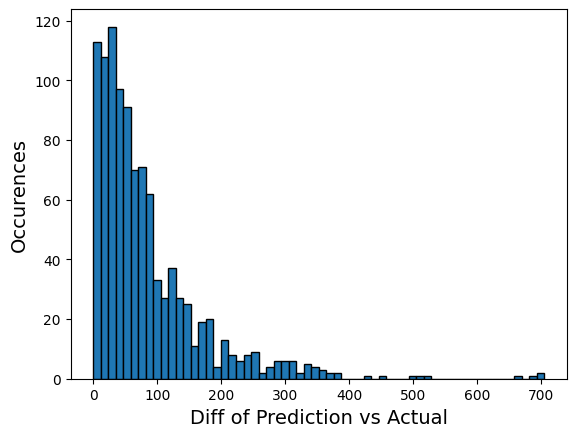

In [ ]:
#Histogram
import matplotlib.pyplot as plt
import numpy as np

data = differences
plt.xlabel('Diff of Prediction vs Actual', fontsize=14)
plt.ylabel('Occurences', fontsize=14)

plt.hist(data, bins=60, edgecolor='black')
plt.show()





In [ ]:
pred = []
actual = []

for index, row in val_data.iterrows():
  # print(f"Prediction for {row['Irradiance']} irradiance:")
  actual.append(row['Irradiance'])
  pred.append(predictions(f"{row['Images']}"))
  # print('\n')

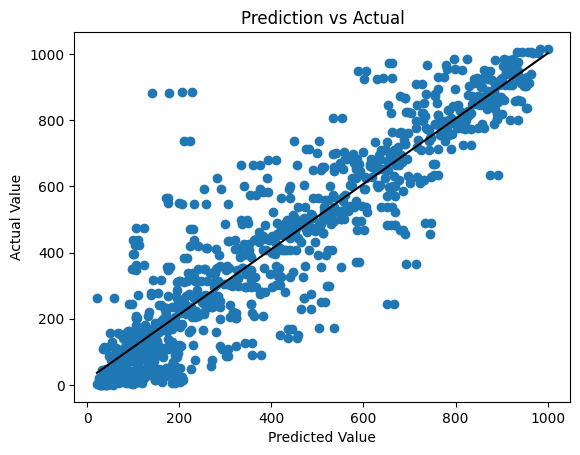

In [ ]:
x = pred
y = actual


plt.scatter(x, y)


slope, intercept = np.polyfit(x, y, 1)

x_line = np.linspace(min(x), max(x), 100)

y_line = slope * x_line + intercept

plt.plot(x_line, y_line, color='black')

plt.title('Prediction vs Actual')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

plt.show()
